In [32]:
from fastai.vision.all import *
from fastai.vision.gan import *
import pathlib
from PIL import ImageDraw, ImageFont
import kornia.losses
import tqdm

# Image Deblurring using FastAI Unet

UNet is a type of architecture commonly used to image-to-image tasks (called image to image translation) like image segmentation and coloring.

See [pix2pix](https://phillipi.github.io/pix2pix/) for examples.

In [2]:
path = untar_data(URLs.PETS)

In [3]:
path = pathlib.Path("data/train")

In [4]:
path_hr = path/ 'original'
path_lr = path/ 'blur'

In [5]:
items = get_image_files(path_hr)

# Prepare dataloaders

We will use simple image augmentations: resized crop, perspective transform and affine transforms.

In [6]:
aug_tfms = [
    RandomResizedCrop(512),
    Warp(),
    Flip(),
    AffineCoordTfm()
]

In [7]:
def get_dls(bs:int, size:int):
    "Generates two `GAN` DataLoaders"
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                     item_tfms=Resize(size),
                    batch_tfms=[*aug_tfms,
                               Normalize.from_stats(*imagenet_stats)]
                    )
    dls = dblock.dataloaders(path_lr, bs=bs)
    dls.c = 3 # For 3 channel image
    return dls 

In [8]:
dls = get_dls(4, 512)

In [9]:
wd, y_range = 1e-3, (-3., 3.)

In [10]:
ssim_loss = partial(kornia.losses.ssim_loss, window_size=5)

# Model setup

We setup UNet with resnet34 as a backbone. Crucially we use SSIM loss from Kornia which is actual competition evaluation metric.

In [19]:
learn = unet_learner(dls, models.resnet34, normalize=True, loss_func=ssim_loss, self_attention=True, y_range=y_range)

In [20]:
learn.model.cuda();

In [16]:
learn.to_fp16()

In [ ]:
learn.path = Path(".")

## First we will train frozen model. 

This will prevent it from overfitting and is useful for seeing whether the model actually learns anything at all.

We start by finding out optimal learning rate

SuggestedLRs(valley=tensor(0.0002))

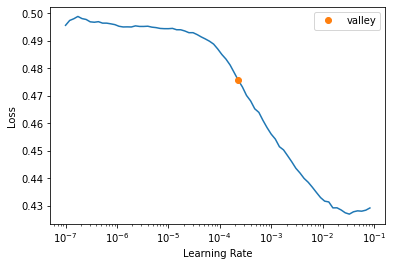

In [18]:
suggested_lr = learn.lr_find()
suggested_lr

epoch,train_loss,valid_loss,time
0,0.275434,0.283865,05:04
1,0.259409,0.274069,05:03
2,0.259618,0.267133,05:04
3,0.257133,0.265066,05:06
4,0.251774,0.264345,05:07


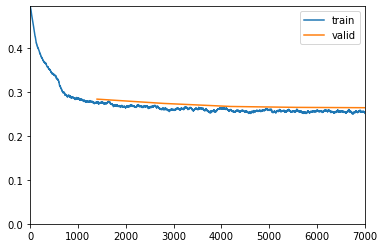

Path('models/unet_resnet34_frozen_norm.pth')

In [19]:
learn.fit_one_cycle(5, lr_max=suggested_lr.valley.item(), wd=wd, cbs=ShowGraphCallback())
learn.save("unet_resnet34_frozen_norm")

## Predicted examples

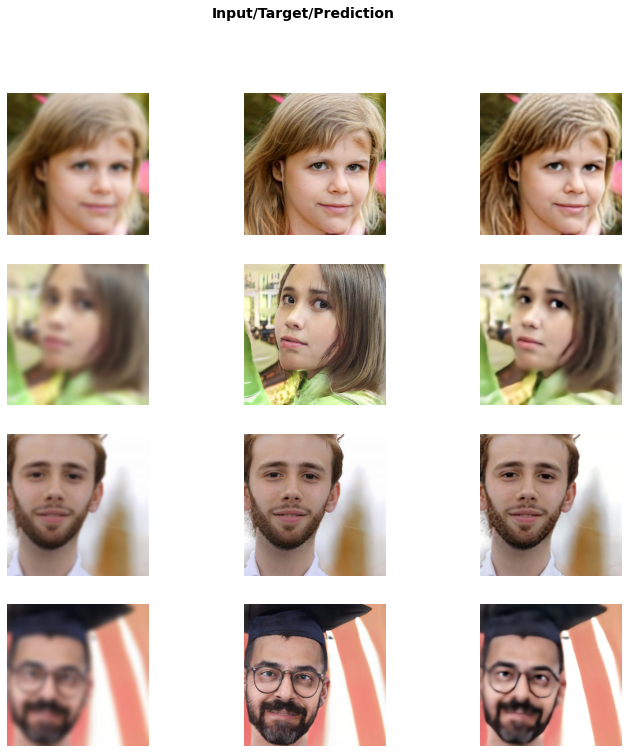

In [20]:
learn.show_results(max_n=4, figsize=(12,12))

In [23]:
#learn.load("unet_resnet34_frozen_norm")

# Unfreezing model

Then we finetune unfreezed model. 

In [24]:
learn.unfreeze()
learn.to_fp16()

In [ ]:
suggested_lr = learn.lr_find()
suggested_lr

In [ ]:
learn.fit_one_cycle(10, suggested_lr.valley.item(), wd=wd, cbs=ShowGraphCallback())
learn.save("unet_resnet34_norm")

In [16]:
#learn.load("unet_resnet34_norm")
#learn.unfreeze()

In [ ]:
learn.show_results(max_n=4, figsize=(12,12))

In [ ]:
suggested_lr = learn.lr_find()
suggested_lr

In [ ]:
learn.fit_one_cycle(5, suggested_lr.valley.item(), wd=wd, cbs=ShowGraphCallback())

In [ ]:
learn.save("unet_resnet34_norm2")

In [ ]:
learn.show_results(max_n=4, figsize=(12,12))

# Test predictions 

we found no significant improvement from unfreezing model, so we just use frozen model.

In [21]:
learn.load("unet_resnet34_frozen")

learn.to_fp16()

In [22]:
path_test = Path("data/test")

In [24]:
path_lr_test = path_test / "blur"

In [25]:
size = 512
bs = 8

test_dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
               get_items=get_image_files,
               get_y = lambda x: path_lr_test/x.name,
               splitter=RandomSplitter(valid_pct=0),
                 item_tfms=Resize(size),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                )
test_dls = test_dblock.dataloaders(path_lr_test, bs=bs)
test_dls.c = 3

In [26]:
dl = test_dls.train.new(shuffle=False, drop_last=False)

In [27]:
preds, __ = learn.get_preds(dl=dl)

In [29]:
path_gen = path_test / "original"

In [33]:
def save_preds(dl, preds):
    "Save away predictions"
    names = dl.dataset.items
    for i,pred in tqdm.tqdm_notebook(enumerate(preds), total=len(preds)):
        dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
        arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
        Image.fromarray(arr).save(path_gen/names[i].name)

In [34]:
save_preds(dl, preds)

<ipython-input-33-1ef24c1f2f5b>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,pred in tqdm.tqdm_notebook(enumerate(preds), total=len(preds)):


  0%|          | 0/3000 [00:00<?, ?it/s]

In [43]:
%%bash
pushd submission
cp ../FastAI_Unet_Deblurring.ipynb notebook.ipynb
cp ../data/test/original/* original
rm submission.zip
zip -r submission.zip * > /dev/null 2>&1
aicrowd submission create -c face-de-blurring -f submission.zip

~/Projects/aicrowd/blitzxiii/face_deblurring/submission ~/Projects/aicrowd/blitzxiii/face_deblurring
submission.zip ━━━━━━━━━━━━━━━━━━━━━ 100.0% • 53.4/53.4 MB • 22.7 MB/s • 0:00:00
                                                   ╭─────────────────────────╮                                                   
                                                   │ Successfully submitted! │                                                   
                                                   ╰─────────────────────────╯                                                   
                                                         Important links                                                         
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/face-de-blurring/submissions/175689              │
│                  │                  

rm: cannot remove 'submission.zip': No such file or directory
